
## Project: Build a Traffic Sign Recognition Classifier


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
import cv2
import random as rnd
import matplotlib.image as mpimg
import pandas as pd
from scipy.ndimage import zoom
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator

C:\Users\ziaeeamir\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


---
## Step 0: Load The Data

---

## Step 1:  Load the data set: Since the dataset is a pickled data that has a dictionary with 4 key pairs, I will use the Pickle Library to load data:

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

 

In [3]:
# Load pickled data
import pickle

# Fill this in based on where you saved the training and testing data

training_file = '../data/train.p'
validation_file='../data/valid.p'
testing_file = '../data/test.p'

with open(training_file,mode='rb') as f:
    train=pickle.load(f)
with open(validation_file,mode='rb') as f:
    valid=pickle.load(f)
with open(testing_file,mode='rb') as f:
    test=pickle.load(f)
x_train,y_train=train['features'],train['labels']
x_valid,y_valid=valid['features'],valid['labels']
x_test,y_test=test['features'],test['labels']

#assert weathers the number of training images and labels are equal
assert(len(x_train)==len(y_train))
assert(len(x_valid)==len(y_valid))
assert(len(x_test)==len(y_test))

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [4]:
print()
print('Image shape{}'.format(x_train[0].shape))
print('Trainini set {} samples'.format(len(x_train)))
print('Validation set {} samples'.format(len(x_valid)))
print('Test set {} samples'.format(len(x_test)))


Image shape(32, 32, 3)
Trainini set 34799 samples
Validation set 4410 samples
Test set 12630 samples


In [7]:
signnames_file='signnames.csv'
data = pd.read_csv(signnames_file,index_col=False) 
# Preview the first 5 lines of the loaded data 
data.head(8)

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)


### Include an exploratory visualization of the dataset

Below is shown some images from the dataset with the coressponding captions:


C:\Users\ziaeeamir\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


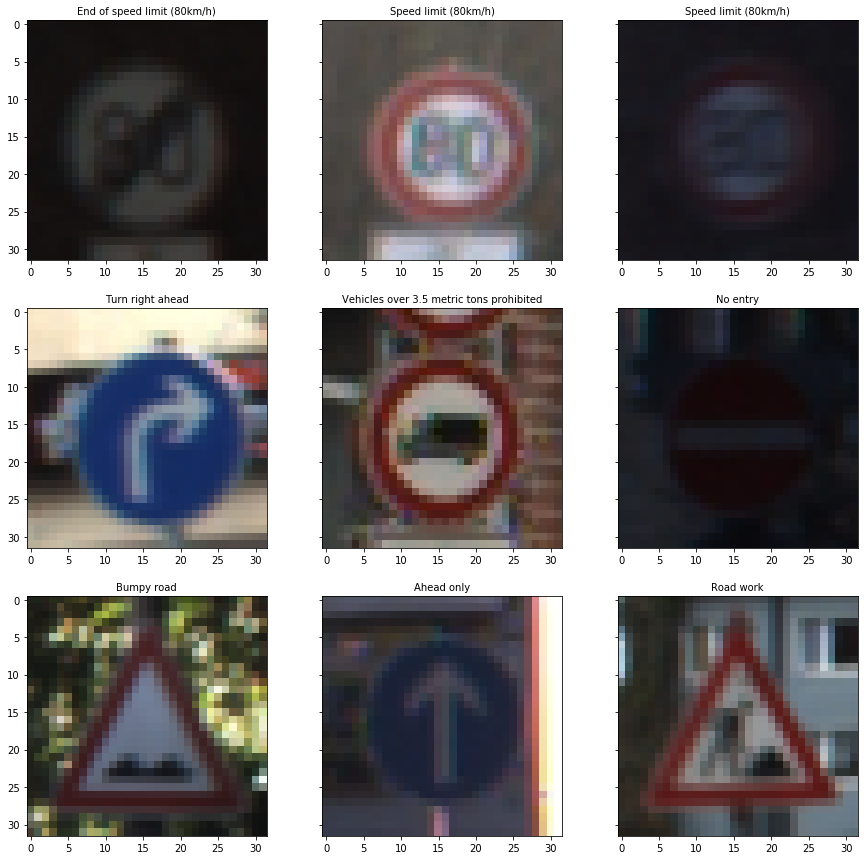

In [10]:
rows = 3
cols = 3
fig, axis = plt.subplots(rows,cols,sharey=True)
fig.set_size_inches(15,15)
for i in range(rows*cols):
    index=rnd.randint(0,len(x_train))
    img=x_train[index]
    label= data.iloc[int(y_train[index])][1]
    axis[int(i/rows)][i%cols].imshow(img,cmap='gray')
    axis[int(i/rows)][i%cols].set_title(str(label),fontsize=10)

    
fig.show()
fig.savefig('./examples/1.png')


I was encouraged to to print several images for each label and try to  pay attention how the images look like. This is important because I need to know the characteristics of the images that you are using for training my model.

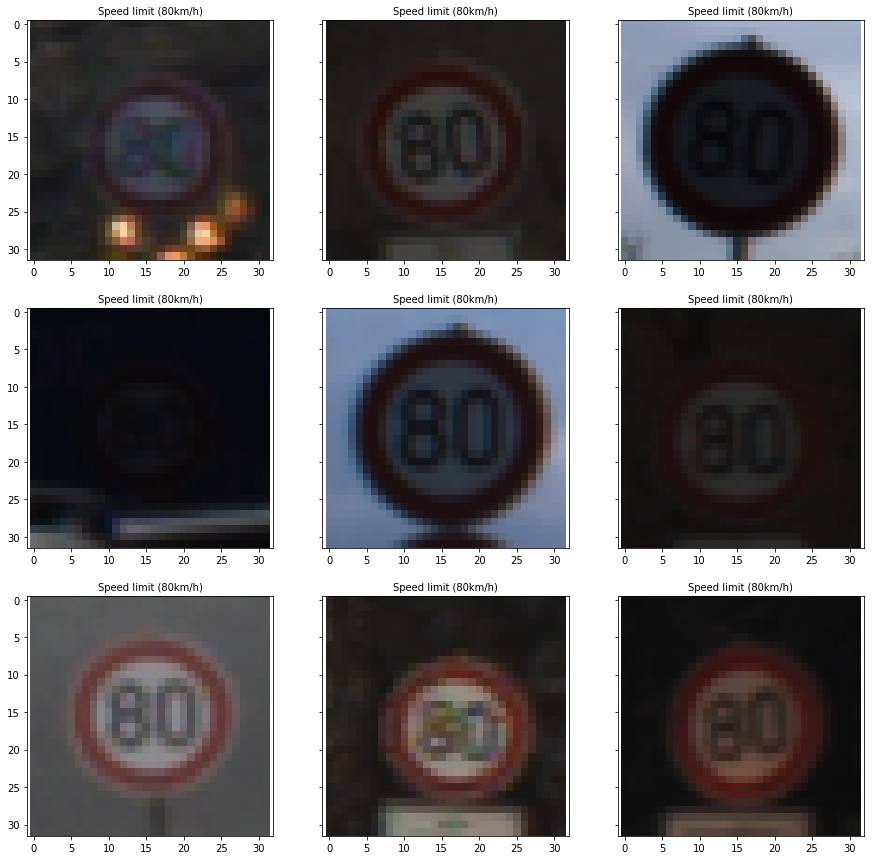

In [6]:
Index_of_label=[i for i, x in enumerate(y_train) if x == 5]
Index_of_label=shuffle(Index_of_label)

rows = 3
cols = 3
fig, axis = plt.subplots(rows,cols,sharey=True)
fig.set_size_inches(15,15)
for i in range(rows*cols):
    img=x_train[Index_of_label[i]]
    label= data.iloc[int(y_train[Index_of_label[i]])][1]
    axis[int(i/rows)][i%cols].imshow(img)
    axis[int(i/rows)][i%cols].set_title(str(label),fontsize=10)
plt.savefig('./examples/2.png')

As seen ,the contrast each imag is bad which must be imporved.

### Pre-process the Data Set (normalization)

# Distribution

Now I am going to explore the distribution and take look at the comparing distribution of  each classes(training ,validation,test).

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


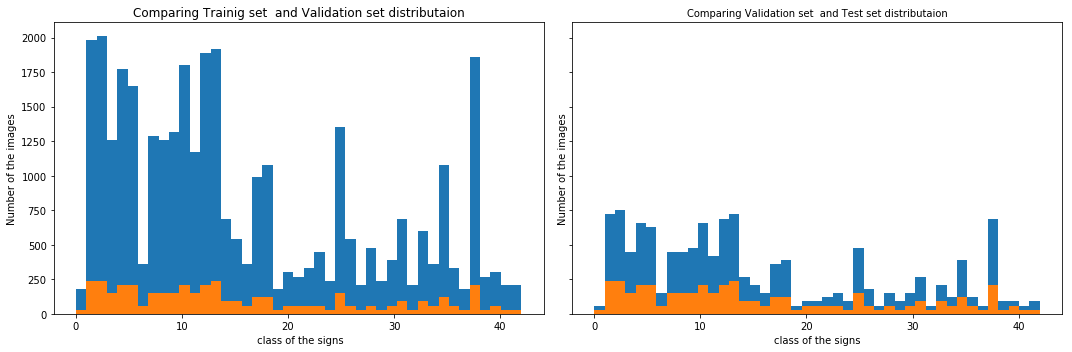

In [7]:
#number of bins is the number of classes
n_bins = len(np.unique(y_train))


#draw a subplot table of 1x3 
fig, axis = plt.subplots(1, 2, sharey=True, tight_layout=True, figsize=[15,5])

axis[0].set_title('Comparing Trainig set  and Validation set distributaion',fontsize=12)
axis[0].set_ylabel('Number of the images')
axis[0].set_xlabel(' class of the signs')


axis[1].set_title('Comparing Validation set  and Test set distributaion',fontsize=10),
axis[1].set_ylabel('Number of the images')
axis[1].set_xlabel('class of the signs')

x_training_h,y_training_h,_=axis[0].hist(y_train,bins=n_bins)
x_valid_h,y_valid_h,_=axis[0].hist(y_valid,bins=n_bins)


x_test_h,y_test_h,_=axis[1].hist(y_test,bins=n_bins)
x_valid_h,y_valid_h,_=axis[1].hist(y_valid,bins=n_bins)

fig.savefig('./examples/3.png')




Then I used the pandas library to calculate summary statistics of the traffic signs data set:


In [8]:
dataframe=pd.DataFrame({'Training data': {'Maximum instances':x_training_h.max(),'Maximum class':data.iloc[int(y_training_h.max())][1],'Minimum instances':x_training_h.min(),'Minimum Class':data.iloc[int(y_training_h.min())][1]},
                       'Validation data': {'Maximum instances':x_valid_h.max(),'Maximum class':data.iloc[int(y_valid_h.max())][1],'Minimum instances':x_valid_h.min(),'Minimum Class':data.iloc[int(y_valid_h.min())][1]},
                       'Test data': {'Maximum instances':x_test_h.max(),'Maximum class':data.iloc[int(y_test_h.max())][1],'Minimum instances':x_test_h.min(),'Minimum Class':data.iloc[int(y_test_h.min())][1]}})

In [9]:
dataframe.T

,Maximum class,Maximum instances,Minimum Class,Minimum instances
Training data,End of no passing by vehicles over 3.5 metric ...,2010,Speed limit (20km/h),180
Validation data,End of no passing by vehicles over 3.5 metric ...,240,Speed limit (20km/h),30
Test data,End of no passing by vehicles over 3.5 metric ...,750,Speed limit (20km/h),60


# Pre-process the Data Set


There are three common forms of data preprocessing:

1-Mean subtraction is the most common form of preprocessing. It involves subtracting the mean across every individual feature in the data, and has the geometric interpretation of centering the cloud of data around the origin along every dimension.
2-Normalization refers to normalizing the data dimensions so that they are of approximately the same scale. 

3-PCA and Whitening is another form of preprocessing. In this process, the data is first centered as described above. Then, we can compute the covariance matrix that tells us about the correlation structure in the data.





 Befor the nomalization all images I converted all images to the LAB  color system(L for lightness and a and b for the color opponents green–red and blue–yellow) to improve the contrast of my images by  using CLAHE (Contrast Limited Adaptive Histogram Equalization) from the opencv librarythen (to only Lightness component and convert back the image to RGB) then I normalized so that the data has mean zero and equal variance.


In [10]:
def LAB_preprocess(data):
    clahe=cv2.createCLAHE(clipLimit=1.5,tileGridSize=(6,6))
    data=data[:,:,:,:]#to gray scale
    dataset=[]
    for i in range (data.shape[0]):
        
        lab = cv2.cvtColor(data[i,:,:,:], cv2.COLOR_BGR2LAB)

        lab_planes = cv2.split(lab)

        lab_planes[0] = clahe.apply(lab_planes[0])

        lab = cv2.merge(lab_planes)

        bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

        dataset.append(bgr)
    

    return dataset

In [11]:
x_train=LAB_preprocess(x_train)
x_valid=LAB_preprocess(x_valid)
x_test=LAB_preprocess(x_test)

# After converting all images to the LAB color system and applying CLAHE

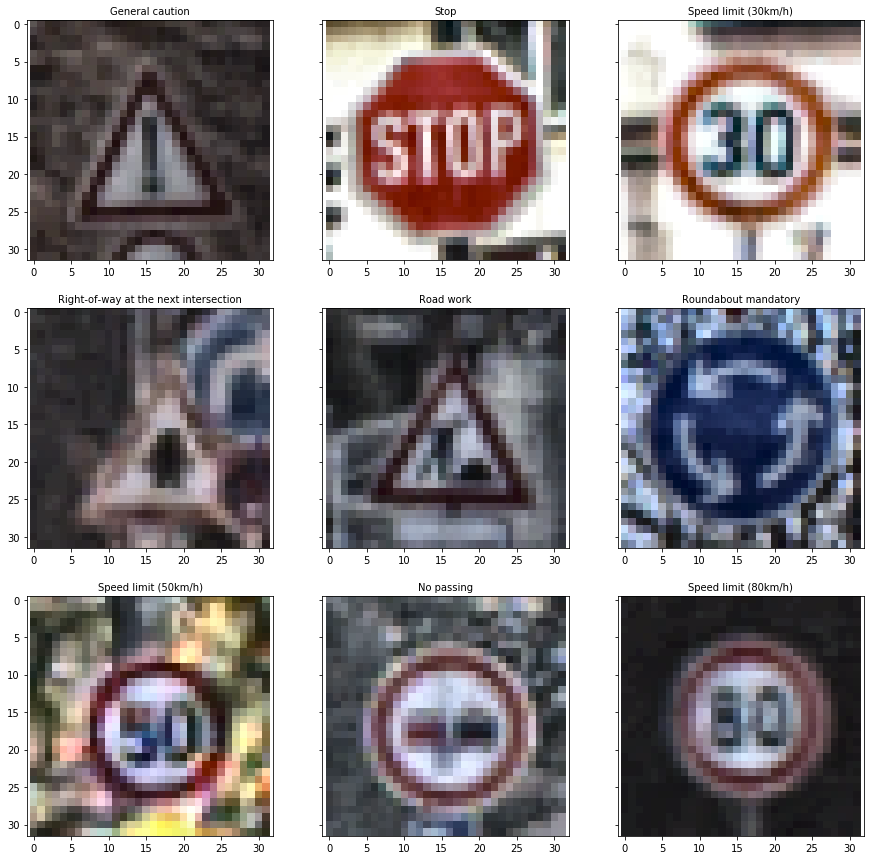

In [12]:
rows = 3
cols = 3
fig, axis = plt.subplots(rows,cols,sharey=True)
fig.set_size_inches(15,15)
for i in range(rows*cols):
    index=rnd.randint(0,len(x_train))
    img=x_train[index]
    label= data.iloc[int(y_train[index])][1]
    axis[int(i/rows)][i%cols].imshow(img,cmap='gray')
    axis[int(i/rows)][i%cols].set_title(str(label),fontsize=10)

    
plt.show()

In [13]:
def normalize(data):
    data=np.array(data)
    print(data.shape)
    data=data.astype('float64')  
    data-= np.mean(data,axis=0)# zero-center the data (important)
    data /=np.std(data,axis=0)
    return data

In [14]:
x_train=normalize(x_train)#new = (1/(2*2.25)) * x_train[0] + 0.5
x_valid=normalize(x_valid)
x_test=normalize(x_test)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


# Data Augmentation
From the histograms above, we can  see that both training set and validation set have similar distribution of traffic sign samples but problem is that there is a huge variability of the distribution between class instances within the dataset,maybe we can develop augmentation techniques to equalize them.


Because of inblancing all dataset I decided to develop the augmentation methods like salt papper noise, rotation and translation methods

In [15]:
def rotate_image(image):
    img=np.copy(image)
    angel=rnd.randint(-20,20)
    w,h,c=img.shape
    Rot_m=cv2.getRotationMatrix2D((w/2,h/2),angel,1)
    img=cv2.warpAffine(img,Rot_m,(w,h))
    return img
    
def translate_image(image):
    img=np.copy(image)
    w,h,c=image.shape
    trans_range=rnd.randint(-20,+20)
    trx_x=trans_range+np.random.uniform()-trans_range/2
    trx_y=trans_range+np.random.uniform()-trans_range/2
    Tran_M=np.float32([[1,0,trx_x],[0,1,trx_y]])
    img=cv2.warpAffine(img,Tran_M,(w,h))
  
    return img

def add_salt_pepper_noise(image):
    img=np.copy(image)
    dice = rnd.randint(0, 100)
    salt_vs_pepper = 0.20
    amount = 0.030
    num_salt = np.ceil(amount * img.size * salt_vs_pepper)
    num_pepper = np.ceil(amount * img.size * (1.0 - salt_vs_pepper))


    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in img.shape]
    img[coords[0], coords[1],:] = 1

    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in img.shape]
    img[coords[0], coords[1],:] = 0

    return img

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


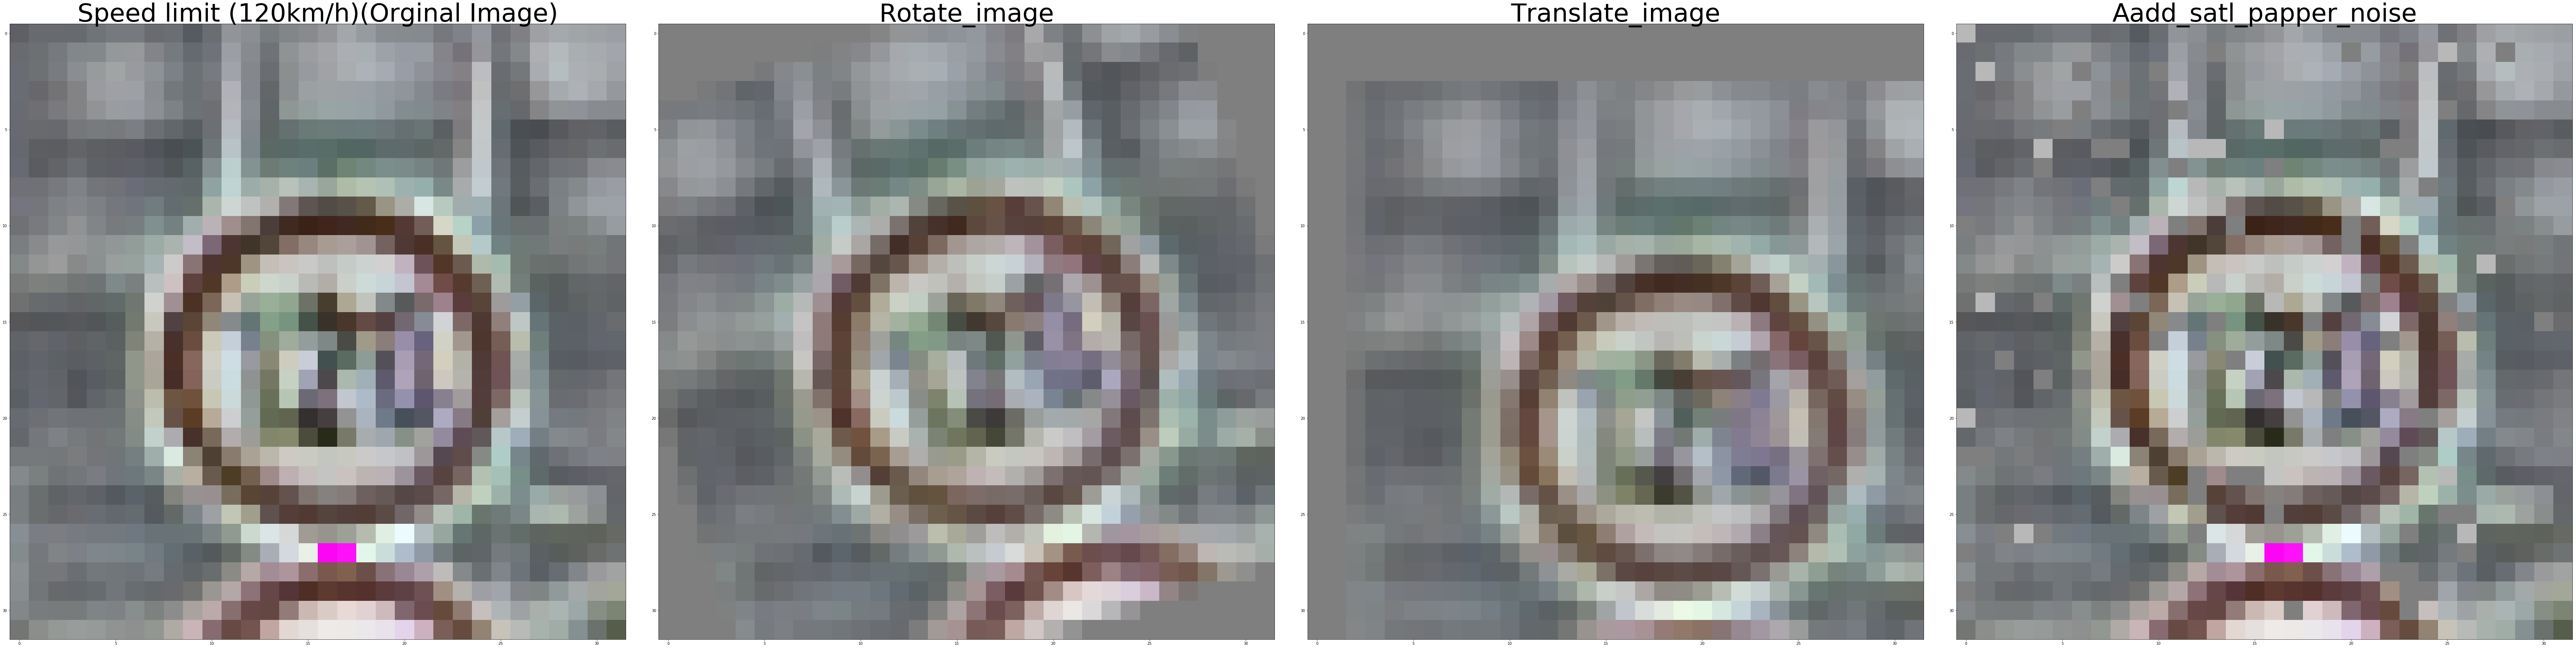

In [16]:


fig, axis = plt.subplots(1,4,sharey=False,tight_layout=True,figsize=(100,100))
#fig.set_size_inches(100,100)
for i in range(rows):
    index=rnd.randint(0,len(x_train))
    image=x_train[index]
    label=data.iloc[y_train[index]][1]
    axis[0].imshow((1/(2*2.25)) * image + 0.5)
    
    axis[0].set_title(str(label)+'(Orginal Image)',fontsize=70)
    Rotated=rotate_image(image)
    axis[1].imshow((1/(2*2.25)) * Rotated + 0.5)
    axis[1].set_title('Rotate_image',fontsize=70)
    
    translated=translate_image(image)
    axis[2].imshow((1/(2*2.25)) * translated + 0.5)
    axis[2].set_title('Translate_image',fontsize=70)
   
    salt_pepper_noise=add_salt_pepper_noise(image)
    axis[3].imshow((1/(2*2.25)) * salt_pepper_noise + 0.5)
    axis[3].set_title('Aadd_satl_papper_noise',fontsize=70)
    
plt.show()
fig.savefig('./examples/4.png')

### I am going to use the random_brightness and flip_left_right function frim Tensorflow for data augmentation.

In [17]:
def horizontal_flip(x:tf.Tensor):
    return tf.image.flip_left_right(x)
def random_brightness(x:tf.Tensor):
    return tf.image.random_brightness(x)

### Model Architecture

1- I chose these hyperparameters based my experiences that I had with the taining phase. I tried to train my model for more epochs to see if I get a better result but I relized that a batch size of 256 can lead to a faster convergence.

2-For visualizing the model architecture, I tried to open the tensorboard environment in the Udacity's workspace (tensorboard --logdir=logs) but I got many errors.




In [18]:
Epoch=5
learning_rate=1e-03
Batch_size=256
initializer = tf.contrib.layers.xavier_initializer()


In [19]:
weights={'conv1':tf.Variable(initializer([7,7,3,64])),
         'fc1':tf.Variable(initializer([49024,1024])),
         'fc2':tf.Variable(initializer([1024,512])),
         'fc3':tf.Variable(initializer([512,128])),
         'out':tf.Variable(initializer([128,43]))}

biasses={'Bconv1':tf.Variable(tf.zeros([64])),
         'Bfc1':tf.Variable(tf.zeros([1024])),
         'Bfc2':tf.Variable(tf.zeros([512])),
         'Bfc3':tf.Variable(tf.zeros([128])),
         'Bout':tf.Variable(tf.zeros([43]))}

In [20]:
from keras.layers import Conv2D
from keras.layers import MaxPool2D
import keras
kernel_init = keras.initializers.glorot_uniform()
bias_init = keras.initializers.Constant(value=0.2)
def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    #shape=(?, 16, 16, 64)
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    #shape=(?, 16, 16, 96)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)
   # shape=(?, 16, 16, 128)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)
    #shape=(?, 16, 16, 32),
    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)
    #shape=(?, 16, 16, 32)
    output = tf.concat([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
 
    return output

The process I did to find my solution was related to the accuracy of the model:

    As known, one of the best archituctue in the fied of deep learing that has achieved much attention is the          inception module. for this reason I used the inception modules to increase the accuracy of my model.
    
    I chosed Adam opzimizer Adam (Adaptive Moment Estimation), In this algorithm, we divide the learning rate for a weight by a running average of the magnitudes of recent gradients for that weight. This helps in faster gradient descent and it is more accurate than SGD and GD
    



In [21]:
def model(data):
    global weights,biasses
    
    incep1 = inception_module(data,
                     filters_1x1=64,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_3a')#(?, 32, 32, 256)
    bincp1=tf.layers.batch_normalization(incep1)
    layer1=tf.nn.relu(bincp1)
    
    

    incep2 = inception_module(layer1,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=192,
                     filters_5x5_reduce=32,
                     filters_5x5=96,
                     filters_pool_proj=64,
                     name='inception_3b') #shape=(?, 32, 32, 480)
    bincep2=tf.layers.batch_normalization(incep2)
    layer2=tf.nn.relu(bincep2)
    layer2 = tf.nn.max_pool(layer2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    incep3 = inception_module(layer2,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=256,
                     filters_5x5_reduce=156,
                     filters_5x5=160,
                     filters_pool_proj=94,
                     name='inception_3c') #shape=(?, 16, 16, 766)
    
    bincep3=tf.layers.batch_normalization(incep3)
    layer3=tf.nn.relu(bincep3)


    
    layer4 = tf.nn.max_pool(layer3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')#shape=(?, 8, 8, 766)
   

   
    layer5=tf.contrib.layers.flatten(layer4) #(?, 49024)
    layer5=tf.add(tf.matmul(layer5,weights['fc1']),biasses['Bfc1'],name='fc1')
    layer5=tf.nn.relu(layer5)
    layer5=tf.nn.dropout(layer5,keep_prob=keep_prob)
    
    layer6=tf.add(tf.matmul(layer5,weights['fc2']),biasses['Bfc2'],name='fc2')
    layer6=tf.nn.relu(layer6)
    layer6=tf.nn.dropout(layer6,keep_prob=keep_prob)


    layer7=tf.add(tf.matmul(layer6,weights['fc3']),biasses['Bfc3'],name='fc3')
    layer7=tf.nn.relu(layer7)
    layer7=tf.nn.dropout(layer7,keep_prob=keep_prob)
    
    layer8=tf.add(tf.matmul(layer7,weights['out']),biasses['Bout'],name='out')
    
    print(layer8)

 
    return layer8 #(?, 43)
    


In [22]:
x=tf.placeholder(tf.float32,(None,32,32,3))
y=tf.placeholder(tf.int32,(None))
one_hot_y=tf.one_hot(y,43)
keep_prob=tf.placeholder(tf.float32)



In [23]:
logits=model(x)
croos_entropy=tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y,logits=logits)
loss_operation=tf.reduce_mean(croos_entropy)
optimizer=tf.train.AdamOptimizer(learning_rate).minimize(loss_operation)

top_predictions = tf.nn.top_k(tf.nn.softmax(logits), k=5)
saver=tf.train.Saver()


Tensor("out:0", shape=(?, 43), dtype=float32)


# Model Evaluation Function

Evaluate how well the loss and accuracy of the model for a given dataset.



In [24]:
correct_prediction=tf.equal(tf.argmax(logits,1),tf.argmax(one_hot_y,1))
accuracy=tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

In [25]:
def evaluate(X_data, y_data):
    num_examples = len(y_data)
    total_accuracy = 0
    total_loss=0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, Batch_size):
     
        x_batch,y_batch=x_train[offset:offset+Batch_size],y_train[offset:offset+Batch_size]
  
        val_acc,loss = sess.run([accuracy,loss_operation], feed_dict={x: x_batch, y: y_batch, keep_prob:1.0})
        total_accuracy += (val_acc * len(x_batch))
        total_loss+=(loss* len(x_batch))

    #print('loss: ',total_loss/num_examples)

    return (total_accuracy / num_examples,total_loss/num_examples)

# Train the Model

Run the training data through the training pipeline to train the model.

Before each epoch, shuffle the training set.

After each epoch, measure the loss and accuracy of the validation set.

Save the model after training.

In [26]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print('Training...')
    for epoch in range(Epoch):
        x_train,y_train=shuffle(x_train,y_train)
        for offset in range(0,len(y_train),Batch_size):
            x_batch,y_batch=x_train[offset:offset+Batch_size],y_train[offset:offset+Batch_size]
            sess.run(optimizer,feed_dict={x:x_batch,y:y_batch,keep_prob:0.5})
        vaild_acc,loss_acc=evaluate(x_valid,y_valid)
        print()
        print('Epoch {} '.format(epoch+1))
        print('Validation Accuracy {:.3f} and Loss validation  {:.3f}  '.format(vaild_acc,loss_acc))
        print()
    writer = tf.summary.FileWriter('logs', sess.graph)
    saver.save(sess,'./SignClassifier.ckpt')
    print('Model Saved')
        

Training...

Epoch 1 
Validation Accuracy 0.264 and Loss validation  2.862  


Epoch 2 
Validation Accuracy 0.692 and Loss validation  1.180  


Epoch 3 
Validation Accuracy 0.895 and Loss validation  0.482  


Epoch 4 
Validation Accuracy 0.978 and Loss validation  0.241  


Epoch 5 
Validation Accuracy 1.002 and Loss validation  0.147  

Model Saved



## Evaluate the Model
Evaluate the performance of the model on the test set.


In [27]:
sess=tf.InteractiveSession()
saver.restore(sess, tf.train.latest_checkpoint('.'))


INFO:tensorflow:Restoring parameters from ./SignClassifier.ckpt


In [28]:
Test_acc,Loss_acc=evaluate(np.expand_dims(x_test,axis=3),y_test)
        
print('Test Accuracy {:.3f} and Loss {:.3f}  '.format(Test_acc,Loss_acc))

Test Accuracy 0.975 and Loss 0.138  


### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [29]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    validation_accuracy,_ = evaluate(np.expand_dims(x_valid,axis=3), y_valid)
    test_accuracy,_ = evaluate(np.expand_dims(x_test,axis=3), y_test)
    train_accuracy,_ = evaluate(np.expand_dims(x_train,axis=3), y_train)

    print('Train Accuracy', train_accuracy)
    print('Validation Accuracy', validation_accuracy)
    print('Test Accuracy', test_accuracy)

INFO:tensorflow:Restoring parameters from ./SignClassifier.ckpt
Train Accuracy 0.963131124369
Validation Accuracy 1.0022675737
Test Accuracy 0.974901029295


---

## Step 3: Test a Model on New Images

To give myself more insight into how your model is working,I downloaded 14 pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the first clear Images

In [171]:
import urllib.request
import glob


urls={'Speed limit (30km/h)':'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTNaCyaWUrCvJvHtqcHPSXjxYSlLapo23sswMIJ3AaInmttEIqlGg', 
      'Beware of ice/snow_30':'https://st2.depositphotos.com/1200828/5228/i/950/depositphotos_52281133-stock-photo-iced-winter-warning-traffic-sign.jpg',
      'Speed limit (120km/h)_8':'https://image.ibb.co/hS8WY8/bc3b76908d05428d944595d1b85f1b78.jpg',
      'Wild animals crossing_31':'https://previews.123rf.com/images/hopre/hopre1601/hopre160100037/50860945-traffic-sign-warns-about-wild-animals-crossing-the-winter-road.jpg',
      'Bicycles crossing_29':'http://www.fyidenmark.com/images/warning_sign.jpg',
      'Right-of-way at the next intersection_11':' https://image.ibb.co/noHTfo/4.jpg'}

path='./examples/'



In [182]:
#To find ClassId   

[data[(data.values.ravel() == i).reshape(data.shape).any(1)] for i in urls]


[   ClassId              SignName
 1        1  Speed limit (30km/h),     ClassId            SignName
 30       30  Beware of ice/snow,    ClassId               SignName
 8        8  Speed limit (120km/h),     ClassId               SignName
 31       31  Wild animals crossing,     ClassId           SignName
 29       29  Bicycles crossing,     ClassId                               SignName
 11       11  Right-of-way at the next intersection]

In [202]:
labels_signs = [1, 30, 8, 31, 29,11]

In [207]:
def download_files(list_url,paht_to_save,ls):
    Name=0
    for i in list_url:
        print(i,ls[Name])
        #print()
        full_file_name=paht_to_save+'T_'+str(ls[Name])+'.png'
        try:
            urllib.request.urlretrieve(list_url[i],full_file_name)
            Name+=1

        except Exception as e:
            print(i)
            raise e 

In [208]:
download_files(urls,path,labels_signs)

Speed limit (30km/h) 1
Beware of ice/snow 30
Speed limit (120km/h) 8
Wild animals crossing 31
Bicycles crossing 29
Right-of-way at the next intersection 11


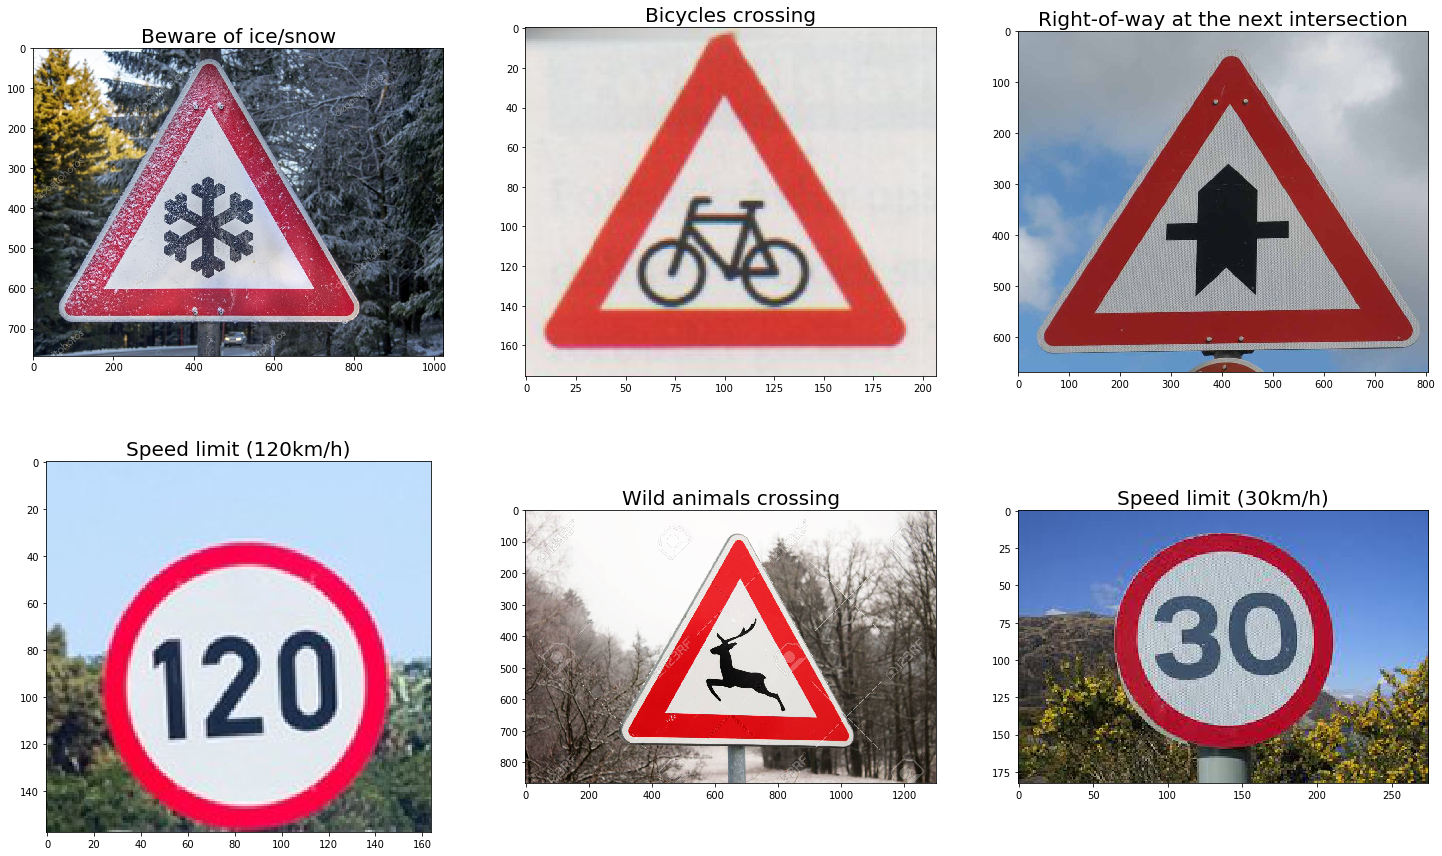

In [212]:
files=glob.glob(path+'T*.png')

rows = 2
cols = 3
fig, axs = plt.subplots(rows,cols)
fig.set_size_inches(25,15)
i=0
for i in range(len(files)):
    image=cv2.imread(files[i])
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    Imagelabel=data.iloc[int((files[i].split('.')[1]).split('_')[1])][1]
    axs[int(i/cols),i%cols].imshow(image)
    axs[int(i/cols)][i%cols].set_title(Imagelabel, fontsize=20)
    

#fig.savefig('./examples/10.jpg')

### Load and Output the noisy Images

In [213]:
files1=glob.glob(path+'T*.jpg')

In [214]:
files1

['./examples/T_27_1.jpg',
 './examples/T_01_1.jpg',
 './examples/T_25_5.jpg',
 './examples/T_01_3.jpg',
 './examples/T_28_0.jpg',
 './examples/T_23_1.jpg',
 './examples/T_00_1.jpg',
 './examples/T-00_2.jpg']

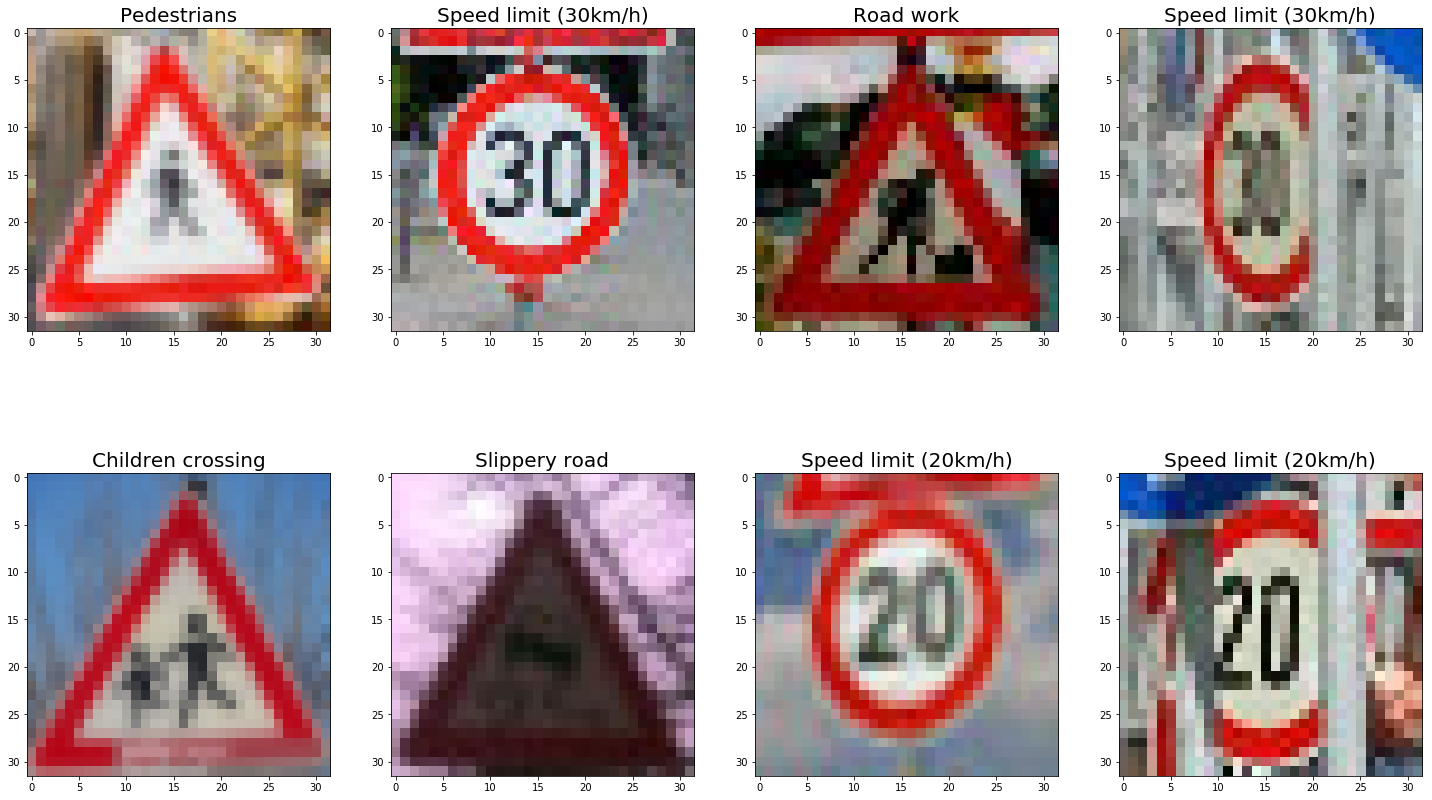

In [215]:

labels1=[27,1,25,1,28,23,0,0]#from the image name

rows = 2
cols = 4
fig, axs = plt.subplots(rows,cols)
fig.set_size_inches(25,15)
i=0
for label, image in zip(labels1,files1):
    image=cv2.imread(image)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    label= data.iloc[labels1[i]][1]
    axs[int(i/cols),i%cols].imshow(image)
    axs[int(i/cols)][i%cols].set_title( label , fontsize=20)
    i+=1

### Predict the Sign Type for the clear Images

In [216]:
top_predicts=[]
images=[]
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    for i in range (len(files)):
        img=cv2.imread(files[i])
        #plt.imshow(img)
        #plt.pause(2)
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img=cv2.resize(img,(32,32),interpolation=cv2.INTER_CUBIC)
        img=normalize(img)
        img=np.expand_dims(img,axis=0) 
        top_predicts.append(sess.run(top_predictions,feed_dict={x:np.array(img),keep_prob:1.0}))
  

INFO:tensorflow:Restoring parameters from ./SignClassifier.ckpt
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)


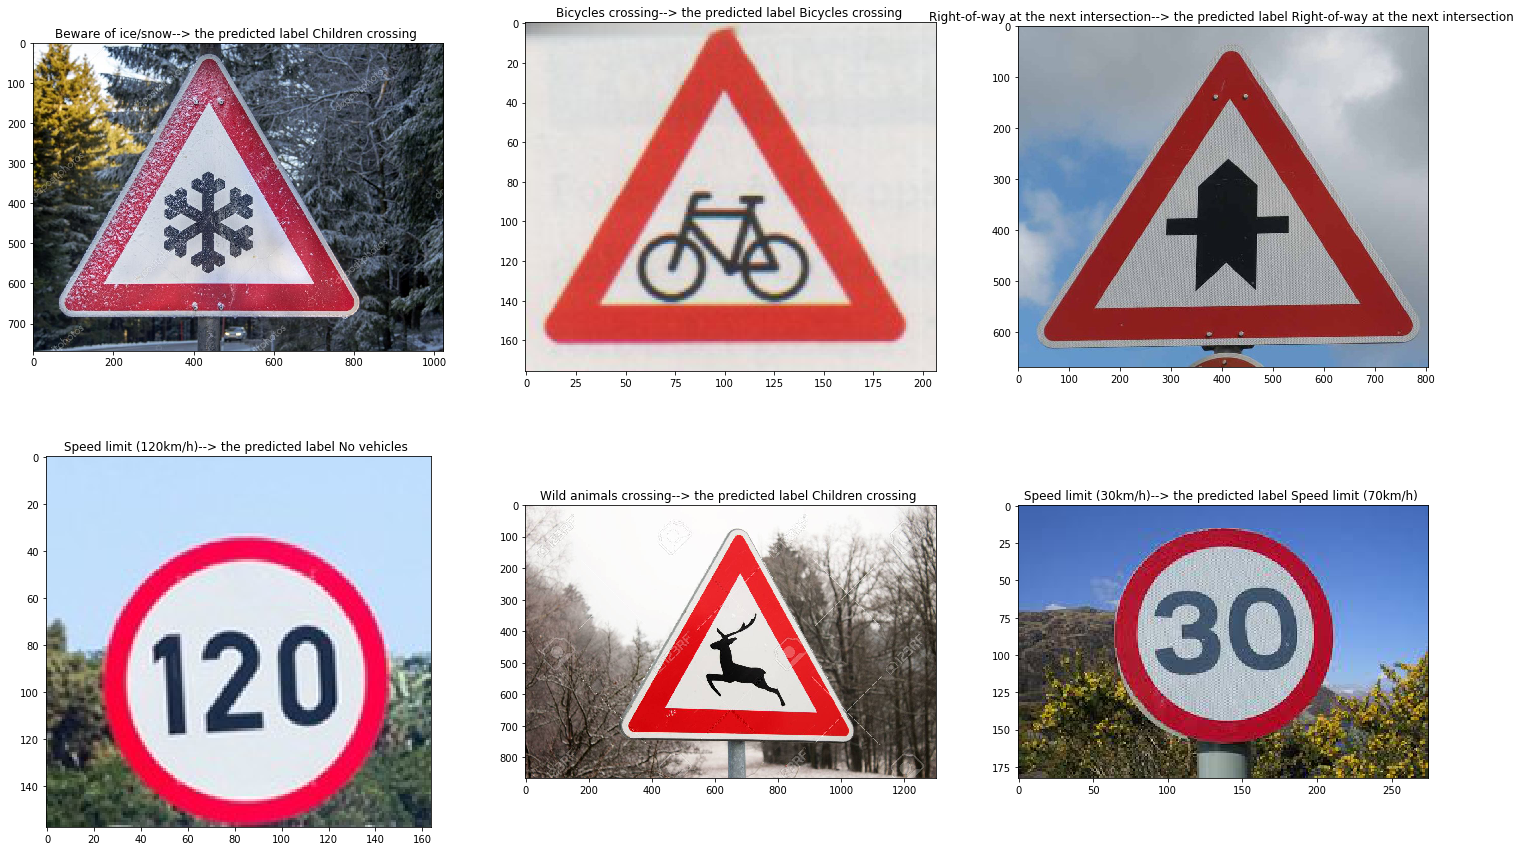

In [230]:
rows = 2
cols = 3
fig, axs = plt.subplots(rows,cols)
fig.set_size_inches(25,15)
for i in range(len(files)):
    image=cv2.imread(files[i])
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    Predictedlabel= data.iloc[top_predicts[i][1][0][0]][1]
    Imagelabel=data.iloc[int((files[i].split('.')[1]).split('_')[1])][1]
    axs[int(i/cols),i%cols].imshow(image)
    axs[int(i/cols)][i%cols].set_title(Imagelabel+('--> the predicted label {} ').format(Predictedlabel, fontsize=20))


fig.savefig('./examples/19.png')

## Predict the Sign Type for the noisy Images

In [242]:
top_predicts1=[]
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    for i in range (len(files1)):
        img=cv2.imread(files1[i])
        #plt.imshow(img)
        #plt.pause(2)
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img=cv2.resize(img,(32,32),interpolation=cv2.INTER_CUBIC)
        img=normalize(img)
        img=np.expand_dims(img,axis=0)

        #print(img.shape)
        top_predicts1.append(sess.run(top_predictions,feed_dict={x:img,keep_prob:1.0}))

INFO:tensorflow:Restoring parameters from ./SignClassifier.ckpt
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)


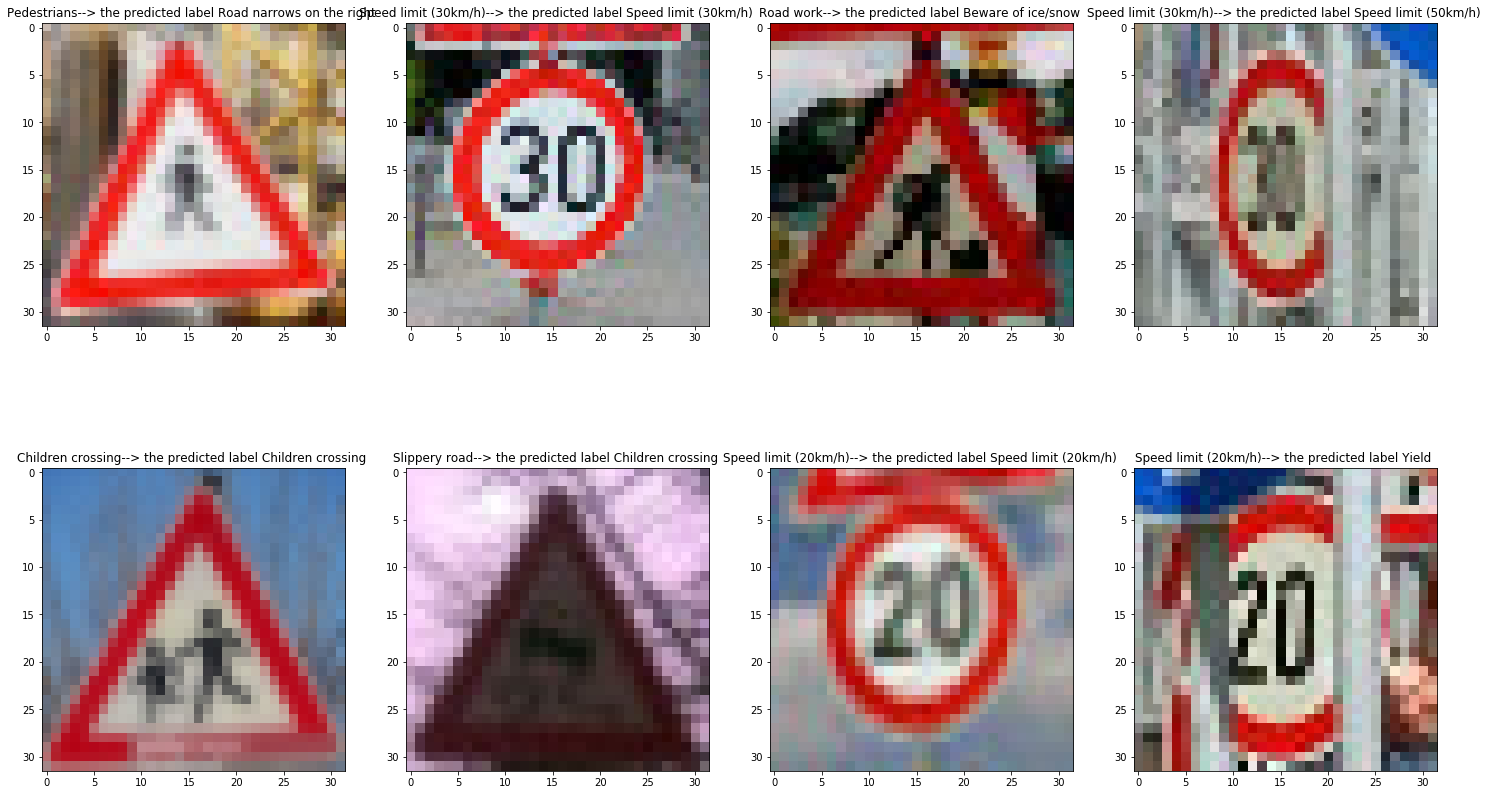

In [247]:


rows = 2
cols = 4
fig, axs = plt.subplots(rows,cols)
fig.set_size_inches(25,15)
i=0
for label, image in zip(labels1,files1):
    image=cv2.imread(image)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    
    labe= data.iloc[label][1]
    predicted=data.iloc[top_predicts1[i][1][0][0]][1]
    axs[int(i/cols),i%cols].imshow(image)
    axs[int(i/cols)][i%cols].set_title(labe+'--> the predicted label {} '.format(predicted, fontsize=20))
    i+=1

fig.savefig('./examples/20.png')

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

# For the clear images

In [253]:
for i in range (len(files)):
    print('------------------------------------------------------------')
    print('The label of the image:{}  is {} which has the corresponding predictions of  {} '.format(i,labels_signs[i],top_predicts[i][1]))

------------------------------------------------------------
The label of the image:0  is 1 which has the corresponding predictions of  [[28 24 11 21 27]] 
------------------------------------------------------------
The label of the image:1  is 30 which has the corresponding predictions of  [[29 28 25 23 30]] 
------------------------------------------------------------
The label of the image:2  is 8 which has the corresponding predictions of  [[11 30 28 24 21]] 
------------------------------------------------------------
The label of the image:3  is 31 which has the corresponding predictions of  [[15  9 23 19 29]] 
------------------------------------------------------------
The label of the image:4  is 29 which has the corresponding predictions of  [[28 29 23 30 24]] 
------------------------------------------------------------
The label of the image:5  is 11 which has the corresponding predictions of  [[4 1 0 2 8]] 


# For the noisy iamges

In [255]:
for i in range (len(files1)):
    print('------------------------------------------------------------')
    print('The label of the image:{}  is {} which has the corresponding predictions of  {} '.format(i, data.iloc[labels1[i]][1],top_predicts1[i][1]))

------------------------------------------------------------
The label of the image:0  is Pedestrians which has the corresponding predictions of  [[24 28 27 30 11]] 
------------------------------------------------------------
The label of the image:1  is Speed limit (30km/h) which has the corresponding predictions of  [[1 0 4 2 5]] 
------------------------------------------------------------
The label of the image:2  is Road work which has the corresponding predictions of  [[30 28 11 24 27]] 
------------------------------------------------------------
The label of the image:3  is Speed limit (30km/h) which has the corresponding predictions of  [[2 5 7 3 1]] 
------------------------------------------------------------
The label of the image:4  is Children crossing which has the corresponding predictions of  [[28 24 30 29 27]] 
------------------------------------------------------------
The label of the image:5  is Slippery road which has the corresponding predictions of  [[28 30 23

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [256]:

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, min(featuremap+1,48)) # sets the number of feature maps to show on each row and column
        #plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")
            

In [257]:
img=x_test[5]
img=np.expand_dims(img,axis=0)
graph = tf.get_default_graph()
conv1= graph.get_tensor_by_name('inception_3a:0')


In [258]:
print(img.shape)
print(conv1)

(1, 32, 32, 3)
Tensor("inception_3a:0", shape=(?, 32, 32, 256), dtype=float32)


INFO:tensorflow:Restoring parameters from ./SignClassifier.ckpt


/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


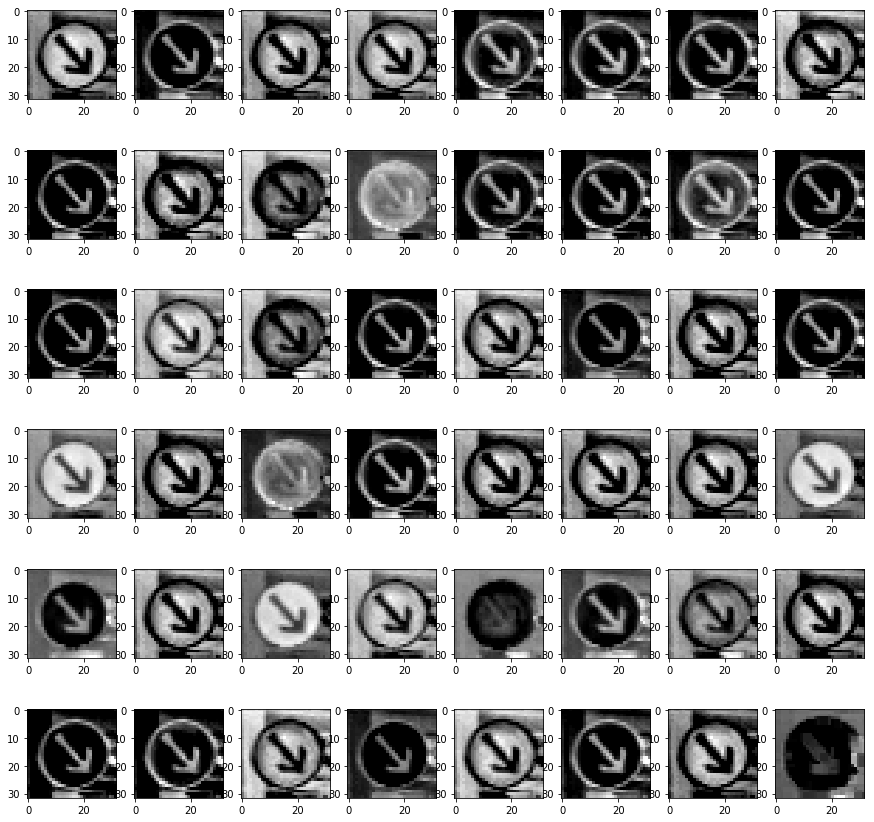

In [259]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    outputFeatureMap(img, conv1)